In [1]:
import optuna
from keras.backend import clear_session
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
%matplotlib inline
from scipy.stats import pearsonr,spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, datetime, traceback
from os.path import exists
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import seaborn as sns
from numpy import concatenate
from scipy import stats
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model
from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from math import sqrt
import sys
sys.path.append('../../../../')
# from keras_tuner import RandomSearch,BayesianOptimization
import IPython
from dataset import Dataset

/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-10-19 20:52:56.889057: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-19 20:52:56.897355: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-19 20:52:56.906146: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024

In [2]:
data = Dataset('1h')
data = data.preprocess()

/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Single-step Predictions/../../../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Single-step Predictions/../../../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Forecasting/Bi-directional LSTM/Single-step Predictions/../../../../dataset.py:71: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x : np.nan if x == '-' else x) # convert - into nan so I can do fillna later
/home/stelios-pc/Desktop/PhD/HALCOR/Experiments/Fore

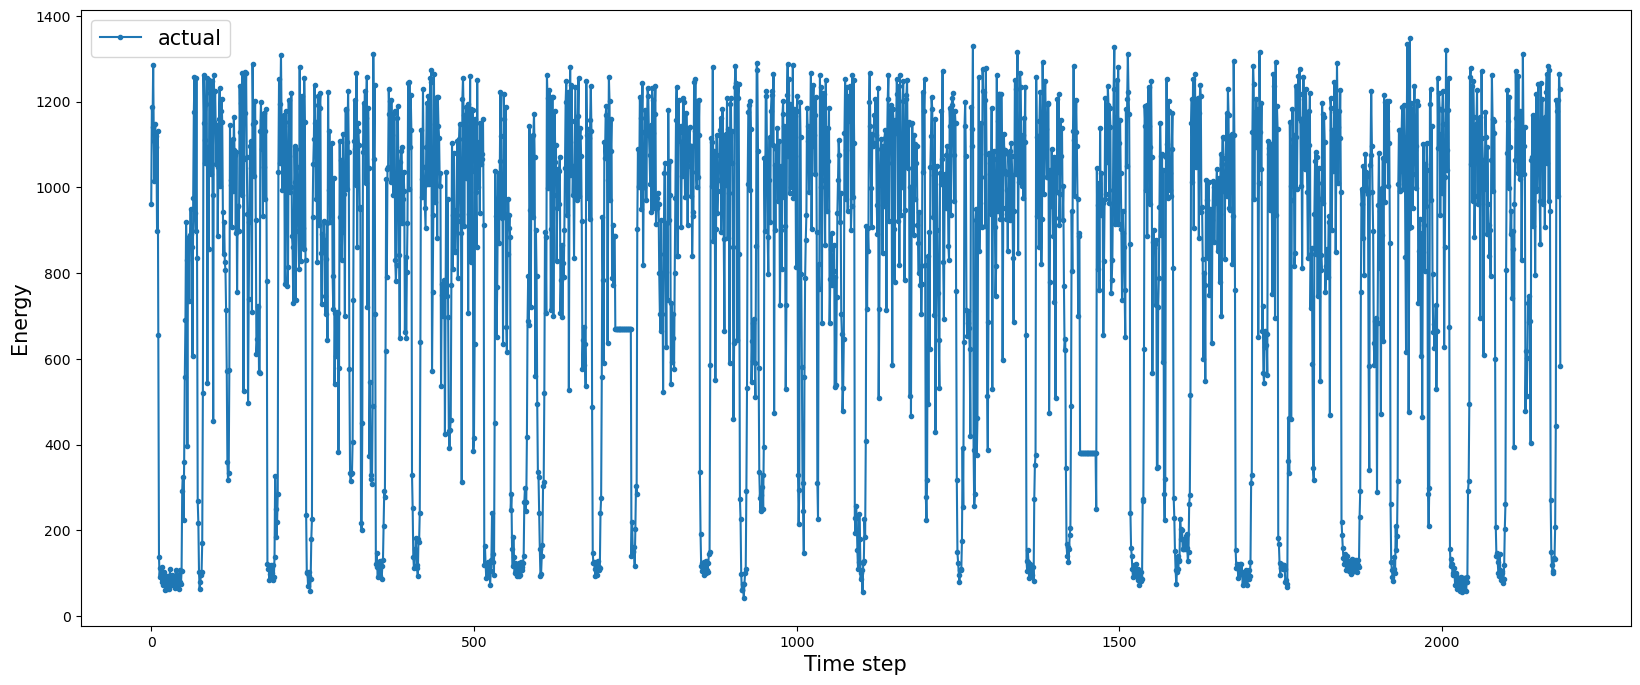

In [3]:
pyplot.figure(figsize=(20,8))
pyplot.plot(data['diff'], label='actual', marker='.')
# pyplot.plot(predictions, label='prediction', color="r")
pyplot.legend()
pyplot.ylabel('Energy', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)

# wandb.log({"True_vs_Predicted": pyplot})
pyplot.show()

In [3]:
data.drop(columns=['Real Energy', 'Duration (min)'], inplace=True)
data.rename(columns={'diff' : 'Energy'}, inplace=True)

# Categorical data
data['Product Group'] = data['Product Group'].apply(lambda x: str(x))
data['Product Group'] = pd.Categorical(data['Product Group'])
data['SKU code'] = data['SKU code'].apply(lambda x: str(x))
data['SKU code'] = pd.Categorical(data['SKU code'])
data['Event Code_plc'] = data['Event Code_plc'].apply(lambda x: str(x))
data['Event Code_plc'] = pd.Categorical(data['Event Code_plc'])
data['Work Center'] = data['Work Center'].apply(lambda x: str(x))
data['Work Center'] = pd.Categorical(data['Work Center'])
data['Event Code_mes'] = data['Event Code_mes'].apply(lambda x: str(x))
data['Event Code_mes'] = pd.Categorical(data['Event Code_mes'])
categorical_data = data.select_dtypes(['category'])

# Numerical data
# scaler = MinMaxScaler() #scaler
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['hour_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['month_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.month / 12)
data['month_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.month / 12)
# data['interval_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
# data['interval_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data = data.drop(columns = ['Timestamp'])
cols = list(data)                 
data = data.drop(columns = ['Product Group', 'SKU code', 'Event Code_plc', 'Work Center', 'Event Code_mes'])
# print(data)
print(data.loc[:, 'Energy'].mean())
print(data.loc[:, 'Energy'].max())
print(data.loc[:, 'Energy'].min())
# numerical_data = scaler.fit_transform(data)

# Forming the sequences for both categorical and numerical data
n_future = 1  # Number of 15-min we want to look into the future based on the past (Out).
n_past = 6  # Number of past 15-min we want to use to predict the future (Step). Basically 4-hours
features = len(cols) - 1  # Number of features

def split_sequence(X, Y, steps, out):
    Xs, Ys = list(), list()
    for i in range(len(X)):
        end = i + steps
        outi = end + out
        if outi > len(X)-1:
            break
        seqx, seqy = X[i:end], Y[end:outi]
        Xs.append(seqx)
        Ys.append(seqy)
    return np.array(Xs), np.array(Ys)


categorical_data = pd.get_dummies(categorical_data, columns = list(categorical_data), dtype=np.int64)
data = pd.concat([data, categorical_data], axis = 1)

X = data.drop(columns='Energy')
Y = data['Energy']
# Train/test splitting
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X.values, Y.values, test_size=0.15, random_state=42, shuffle= False)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle= False)
X_train, Y_train = X_train_temp, y_train_temp


#scale only the training data, and then apply to the rest of the splits. Also two scalers, for X and Y
# n_samples, n_timesteps, n_features = X_train.shape
# X_train_reshaped = X_train.reshape(n_samples * n_timesteps, n_features)
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
# X_train = X_train_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

# n_samples, n_timesteps, n_features = Y_train.shape
# Y_train_reshaped = Y_train.reshape(n_samples * n_timesteps, n_features)
scaler_Y = MinMaxScaler()
Y_train = scaler_Y.fit_transform(Y_train.reshape(-1, 1))
# Y_train = Y_train_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)


#scale val/test sets
# X_val_reshaped = X_val.reshape(X_val.shape[0] * X_val.shape[1], X_val.shape[2])
X_val = scaler_X.transform(X_val)
# Y_val_reshaped = Y_val.reshape(Y_val.shape[0] * Y_val.shape[1], Y_val.shape[2])
Y_val = scaler_Y.transform(Y_val.reshape(-1, 1))

# X_test_reshaped = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])
X_test = scaler_X.transform(X_test)
# Y_test_reshaped = Y_test.reshape(Y_test.shape[0] * Y_test.shape[1], Y_test.shape[2])
Y_test = scaler_Y.transform(Y_test.reshape(-1, 1))


print("Train sizes:")
print(X_train.shape,Y_train.shape)
print("Validation sizes:")
print(X_val.shape,Y_val.shape)
print("Test sizes:")
print(X_test.shape,Y_test.shape)

X_train , Y_train =  split_sequence(X_train, Y_train, n_past, n_future)
X_val , Y_val =  split_sequence(X_val, Y_val, n_past, n_future)
X_test , Y_test =  split_sequence(X_test, Y_test, n_past, n_future)

790.7322703754638
1348.9569999948144
43.16499999910593
Train sizes:
(1856, 423) (1856, 1)
Validation sizes:
(164, 423) (164, 1)
Test sizes:
(164, 423) (164, 1)


In [5]:
import optuna
from keras.backend import clear_session
from keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
%matplotlib inline
from scipy.stats import pearsonr,spearmanr
import pandas as pd
import matplotlib.pyplot as plt
import csv, os, datetime, traceback
from os.path import exists
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import seaborn as sns
from numpy import concatenate
from scipy import stats
from matplotlib import pyplot
from tensorflow import keras
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Concatenate
from tensorflow.keras.models import Model

from keras.models import Sequential, load_model, save_model
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import MaxPooling1D
from keras.layers import Conv1D
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score
from math import sqrt
from scikeras.wrappers import KerasRegressor
import sys
# from keras_tuner import RandomSearch,BayesianOptimization
import IPython


class LearningRateLogger(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.learning_rate
        current_lr = float(keras.backend.get_value(lr))
        print(f"\nEpoch {epoch+1}: Learning rate is {current_lr}")

lr_schedule = ExponentialDecay(
    0.001, decay_steps=1200, decay_rate=0.96, staircase=True
)

def create_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(256, activation='relu', return_sequences=True, dropout= 0.1, recurrent_dropout= 0.3, input_shape=(X_train.shape[1], X_train.shape[2]))))
    model.add(Bidirectional(LSTM(256 *2, activation='relu', return_sequences=True, dropout= 0.2, recurrent_dropout= 0.1)))
    model.add(Bidirectional(LSTM(256 *4, activation='relu', return_sequences=True, dropout= 0.1, recurrent_dropout= 0.1)))
    model.add(TimeDistributed(Dense(32, activation='relu')))
    model.add(Dropout(0.1))
    model.add(TimeDistributed(Dense(1)))
    model.add(Flatten())
    model.add(Dense(n_future))
    optimizer = Adam(learning_rate=lr_schedule)
    model.compile(loss='mse', optimizer=optimizer, metrics=['mae', 'mape'])
    return model

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    './models/model-1-hour(1h).keras',        # Path to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=True,    # Save only the best model
    mode='min',             # Save when the quantity monitored has stopped decreasing
    verbose=1               # Verbosity mode
)
model = create_model()
history = model.fit(X_train, Y_train[:, :, 0], validation_data=(X_val, Y_val[:, :, 0]), epochs=45, batch_size=8, callbacks=[checkpoint_callback, LearningRateLogger()], verbose=1, shuffle=False)

Epoch 1/45


I0000 00:00:1729360706.637000   57120 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729360706.668838   57120 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729360706.669028   57120 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1729360706.669925   57120 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

  7/232 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 0.1806 - mae: 0.2983 - mape: 254.1369

I0000 00:00:1729360716.546073   58099 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


232/232 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 0.1448 - mae: 0.3086 - mape: 131869.1094
Epoch 1: val_loss improved from inf to 0.06485, saving model to ./models/model-1-hour(1h).keras

Epoch 1: Learning rate is 0.0010000000474974513
232/232 ━━━━━━━━━━━━━━━━━━━━ 21s 48ms/step - loss: 0.1446 - mae: 0.3085 - mape: 132104.9375 - val_loss: 0.0648 - val_mae: 0.2072 - val_mape: 149.8788
Epoch 2/45
231/232 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1078 - mae: 0.2754 - mape: 178836.1562
Epoch 2: val_loss improved from 0.06485 to 0.06136, saving model to ./models/model-1-hour(1h).keras

Epoch 2: Learning rate is 0.0010000000474974513
232/232 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 0.1076 - mae: 0.2751 - mape: 179478.9062 - val_loss: 0.0614 - val_mae: 0.1894 - val_mape: 62.0872
Epoch 3/45
229/232 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0723 - mae: 0.2176 - mape: 153861.6719
Epoch 3: val_loss did not improve from 0.06136

Epoch 3: Learning rate is 0.0010000000474974513
232/232 ━━━━━━━━━

KeyboardInterrupt: 

In [6]:
from keras.models import load_model
# load model

model = load_model('./models/model-1-hour(1h).keras')
predictions = model.predict(X_test)

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step


In [7]:
predictions.shape

(157, 1)

In [9]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error

zeros = np.zeros((X_test.shape[0], 35))
for i in range(zeros.shape[0]):
    zeros[i][0] = predictions[i]


predictions = scaler_Y.inverse_transform(zeros)
predictions = [i[0] for i in predictions]

zeros = np.zeros((X_test.shape[0],35))
for i in range(zeros.shape[0]):
    zeros[i][0] = Y_test[i]
original = scaler_Y.inverse_transform(zeros)
original = [i[0] for i in original]

# Calculate metrics
def adjusted_r2(r2, n, p):
    """
    Calculate the adjusted R² score.
    :param r2: The R² score.
    :param n: Number of data points.
    :param p: Number of features.
    :return: Adjusted R² score.
    """
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Function to calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate the Mean Absolute Percentage Error (MAPE).
    :param y_true: Actual values.
    :param y_pred: Predicted values.
    :return: MAPE value.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mae = mean_absolute_error(original, predictions)
mse = mean_squared_error(original, predictions)
rmse = np.sqrt(mse)  # Calculate RMSE
r2 = r2_score(original, predictions)
median_ae = median_absolute_error(original, predictions)
mape = mean_absolute_percentage_error(original, predictions)


n = len(original)
p = X_test.shape[1] 
adjusted_r2_value = adjusted_r2(r2, n, p)
# Print the metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')
print(f"Adjusted R² Score: {adjusted_r2_value}")
print(f"Median Absolute Error: {median_ae}")
print(f"Mean Absolute Percentage Error (MAPE): {mape} %")

Mean Absolute Error (MAE): 194.73941638812107
Mean Squared Error (MSE): 83696.78787020971
Root Mean Squared Error (RMSE): 289.3039714041439
R² Score: 0.5481898359770763
Adjusted R² Score: 0.5301174294161592
Median Absolute Error: 125.48916159298142
Mean Absolute Percentage Error (MAPE): 54.28356187756451 %


/tmp/ipykernel_57120/2909721604.py:5: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeros[i][0] = predictions[i]
/tmp/ipykernel_57120/2909721604.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeros[i][0] = Y_test[i]


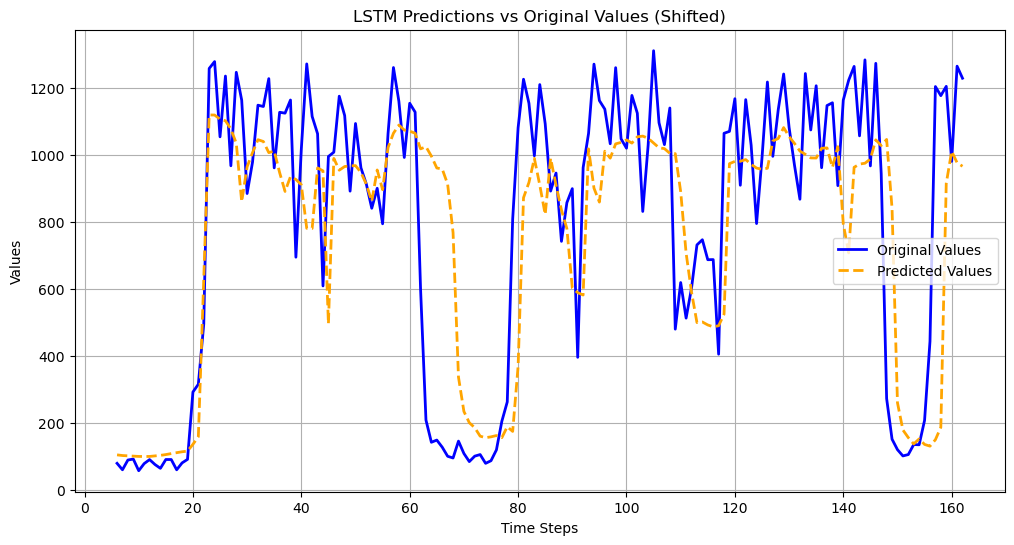

In [10]:
# Convert predictions and original to numpy arrays if they are lists
predictions = np.array(predictions)  # Ensure predictions is a numpy array
original = np.array(original)          # Ensure original is a numpy array

# Define look_back period
look_back = 6  # This should match how you framed your LSTM input

# Prepare predictions and original arrays for plotting
# Use NaN for shifted space
predictions_plot = np.full((len(predictions) + look_back,), np.nan)  
original_plot = np.full((len(original) + look_back,), np.nan)  

# Fill the predictions starting from look_back index
predictions_plot[look_back:look_back + len(predictions)] = predictions.flatten()  # Shifted predictions

# Fill the original values starting from look_back index
original_plot[look_back:look_back + len(original)] = original  # Shifted original values

# Plotting
plt.figure(figsize=(12, 6))

# Plot original values
plt.plot(original_plot, label='Original Values', color='blue', linewidth=2)

# Plot shifted predictions
plt.plot(predictions_plot, label='Predicted Values', color='orange', linestyle='--', linewidth=2)

# Add titles and labels
plt.title('LSTM Predictions vs Original Values (Shifted)')
plt.xlabel('Time Steps')  # Adjust this label as needed for your specific context
plt.ylabel('Values')  # Adjust this label to match your data context
plt.legend()
plt.grid()
plt.show()

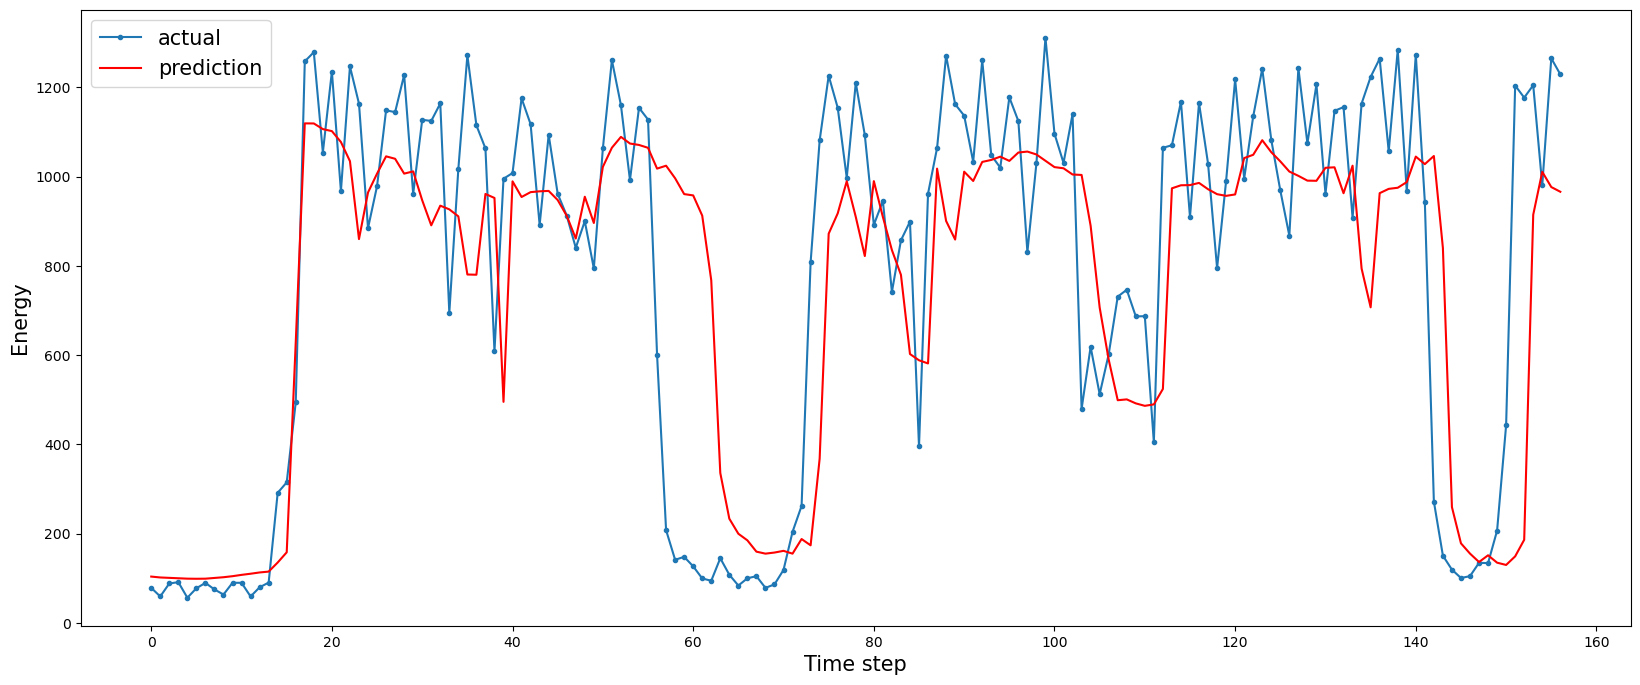

In [11]:
pyplot.figure(figsize=(20,8))
pyplot.plot(original, label='actual', marker='.')
pyplot.plot(predictions, label='prediction', color="r")
pyplot.legend()
pyplot.ylabel('Energy', size=15)
pyplot.xlabel('Time step', size=15)
pyplot.legend(fontsize=15)

# wandb.log({"True_vs_Predicted": pyplot})
pyplot.show()

# Trying XGBoost for the coarser intervals

In [12]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler


In [13]:
# data = Dataset('4h')
# data = data.preprocess()
data = pd.read_csv('/home/stelios-pc/Desktop/PhD/HALCOR/Data/data.csv')
# data['Timestamp'] = pd.to_datetime(data['Timestamp'])
# start_time = pd.Timestamp('2022-05-31 07:00:00')
# end_time = pd.Timestamp('2022-06-01 07:30:00')
# data = data[~((data['Timestamp'] >= start_time) & (data['Timestamp'] <= end_time))]
# start_time = pd.Timestamp('2022-05-31 08:00:00')
# end_time = pd.Timestamp('2022-06-01 09:00:00')
# data = data[~((data['Timestamp'] >= start_time) & (data['Timestamp'] <= end_time))]
# data.to_csv('/home/stelios-pc/Desktop/PhD/HALCOR/temp.csv')
data.drop(columns=['Unnamed: 0', 'Real Energy', 'Duration (min)'], inplace=True)
data.rename(columns={'diff' : 'Energy'}, inplace=True)

In [14]:
# Assuming your data is in a pandas DataFrame df with 'target' column to predict
data['lag_1'] = data['Energy'].shift(1)
data['lag_2'] = data['Energy'].shift(2)
data['lag_3'] = data['Energy'].shift(3)
data['lag_4'] = data['Energy'].shift(4)


# Categorical data
data['Product Group'] = data['Product Group'].apply(lambda x: str(x))
data['Product Group'] = pd.Categorical(data['Product Group'])
data['SKU code'] = data['SKU code'].apply(lambda x: str(x))
data['SKU code'] = pd.Categorical(data['SKU code'])
data['Event Code_plc'] = data['Event Code_plc'].apply(lambda x: str(x))
data['Event Code_plc'] = pd.Categorical(data['Event Code_plc'])
data['Work Center'] = data['Work Center'].apply(lambda x: str(x))
data['Work Center'] = pd.Categorical(data['Work Center'])
data['Event Code_mes'] = data['Event Code_mes'].apply(lambda x: str(x))
data['Event Code_mes'] = pd.Categorical(data['Event Code_mes'])
categorical_data = data.select_dtypes(['category'])

# Numerical data
# scaler = MinMaxScaler() #scaler
data['Timestamp'] = pd.to_datetime(data['Timestamp'])
data['hour_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['hour_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.hour / 24)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.dayofweek / 7)
data['month_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.month / 12)
data['month_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.month / 12)
# data['interval_sin'] = np.sin(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
# data['interval_cos'] = np.cos(2 * np.pi * data['Timestamp'].dt.minute // 15 / 4)
data = data.drop(columns = ['Timestamp'])
cols = list(data)                 
data = data.drop(columns = ['Product Group', 'SKU code', 'Event Code_plc', 'Work Center', 'Event Code_mes'])
# print(data)
print(data.loc[:, 'Energy'].mean())
print(data.loc[:, 'Energy'].max())
print(data.loc[:, 'Energy'].min())
# numerical_data = scaler.fit_transform(data)
features = len(cols) - 1  # Number of features


categorical_data = pd.get_dummies(categorical_data, columns = list(categorical_data), dtype=np.int64)
data = pd.concat([data, categorical_data], axis = 1)

X = data.drop(columns='Energy')
Y = data['Energy']
# Train/test splitting
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X.values, Y.values, test_size=0.15, random_state=42, shuffle= False)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, shuffle= False)
X_train, Y_train = X_train_temp, y_train_temp


#scale only the training data, and then apply to the rest of the splits. Also two scalers, for X and Y
# n_samples, n_timesteps, n_features = X_train.shape
# X_train_reshaped = X_train.reshape(n_samples * n_timesteps, n_features)
scaler_X = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
# X_train = X_train_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)

# n_samples, n_timesteps, n_features = Y_train.shape
# Y_train_reshaped = Y_train.reshape(n_samples * n_timesteps, n_features)
scaler_Y = MinMaxScaler()
Y_train = scaler_Y.fit_transform(Y_train.reshape(-1, 1))
# Y_train = Y_train_scaled_reshaped.reshape(n_samples, n_timesteps, n_features)


#scale val/test sets
# X_val_reshaped = X_val.reshape(X_val.shape[0] * X_val.shape[1], X_val.shape[2])
X_val = scaler_X.transform(X_val)
# Y_val_reshaped = Y_val.reshape(Y_val.shape[0] * Y_val.shape[1], Y_val.shape[2])
Y_val = scaler_Y.transform(Y_val.reshape(-1, 1))

# X_test_reshaped = X_test.reshape(X_test.shape[0] * X_test.shape[1], X_test.shape[2])
X_test = scaler_X.transform(X_test)
# Y_test_reshaped = Y_test.reshape(Y_test.shape[0] * Y_test.shape[1], Y_test.shape[2])
Y_test = scaler_Y.transform(Y_test.reshape(-1, 1))


print("Train sizes:")
print(X_train.shape,Y_train.shape)
print("Validation sizes:")
print(X_val.shape,Y_val.shape)
print("Test sizes:")
print(X_test.shape,Y_test.shape)

train_data = xgb.DMatrix(X_train, label=Y_train)
val_data = xgb.DMatrix(X_val, label=Y_val)
test_data = xgb.DMatrix(X_test, label=Y_test)
params = {
    'objective': 'reg:squarederror',  # Use squared error for regression
    'eval_metric': 'rmse',  # Root Mean Squared Error as evaluation metric
    'learning_rate': 0.001,  # Small learning rate to avoid overfitting
    'max_depth': 5,         # Controls the complexity of the model (higher values may overfit)
    'n_estimators': 10000,    # Number of boosting rounds (you can tune this)
    'early_stopping_rounds': 50,  # Stop if there's no improvement after 50 rounds
    'alpha' : 0.1,
    'lambda' : 0.1,
}
# Use a validation set to avoid overfitting
evals = [(train_data, 'train'), (val_data, 'eval')]

# Train the XGBoost model
model = xgb.train(params, train_data, num_boost_round=10000, evals=evals, early_stopping_rounds=50, verbose_eval=100)
y_pred = model.predict(test_data)
# Calculate metrics


790.7322703754638
1348.9569999948144
43.16499999910593
Train sizes:
(1856, 427) (1856, 1)
Validation sizes:
(164, 427) (164, 1)
Test sizes:
(164, 427) (164, 1)
[0]	train-rmse:0.30194	eval-rmse:0.31508


/home/stelios-pc/anaconda3/envs/tensorflow_gpu/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [21:03:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722516643542/work/src/learner.cc:740: 
Parameters: { "early_stopping_rounds", "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


[100]	train-rmse:0.27810	eval-rmse:0.29128
[200]	train-rmse:0.25687	eval-rmse:0.27016
[300]	train-rmse:0.23802	eval-rmse:0.25140
[400]	train-rmse:0.22115	eval-rmse:0.23465
[500]	train-rmse:0.20614	eval-rmse:0.21997
[600]	train-rmse:0.19281	eval-rmse:0.20723
[700]	train-rmse:0.18098	eval-rmse:0.19597
[800]	train-rmse:0.17045	eval-rmse:0.18590
[900]	train-rmse:0.16109	eval-rmse:0.17696
[1000]	train-rmse:0.15279	eval-rmse:0.16905
[1100]	train-rmse:0.14540	eval-rmse:0.16283
[1200]	train-rmse:0.13892	eval-rmse:0.15699
[1300]	train-rmse:0.13329	eval-rmse:0.15219
[1400]	train-rmse:0.12834	eval-rmse:0.14783
[1500]	train-rmse:0.12394	eval-rmse:0.14459
[1600]	train-rmse:0.12000	eval-rmse:0.14169
[1700]	train-rmse:0.11643	eval-rmse:0.13902
[1800]	train-rmse:0.11314	eval-rmse:0.13714
[1900]	train-rmse:0.11014	eval-rmse:0.13569
[2000]	train-rmse:0.10742	eval-rmse:0.13442
[2100]	train-rmse:0.10493	eval-rmse:0.13317
[2200]	train-rmse:0.10267	eval-rmse:0.13203
[2300]	train-rmse:0.10068	eval-rmse:0.130

In [15]:
# descale
test_data_len = test_data.get_data()
zeros = np.zeros((test_data_len.shape[0], 39))
for i in range(zeros.shape[0]):
    zeros[i][0] = y_pred[i]

predictions = scaler_Y.inverse_transform(zeros)
predictions = [i[0] for i in predictions]

zeros = np.zeros((test_data_len.shape[0],39))
for i in range(zeros.shape[0]):
    zeros[i][0] = Y_test[i]
original = scaler_Y.inverse_transform(zeros)
original = [i[0] for i in original]

mae = mean_absolute_error(original, predictions)
rmse = np.sqrt(mean_squared_error(original, predictions))
r2 = r2_score(original, predictions)
n = len(original)
p = test_data_len.shape[1]
def adjusted_r2(r2, n, p):
    """
    Calculate the adjusted R² score.
    :param r2: The R² score.
    :param n: Number of data points.
    :param p: Number of features.
    :return: Adjusted R² score.
    """
    return 1 - ((1 - r2) * (n - 1) / (n - p - 1))
adjusted_r2_value = adjusted_r2(r2, n, p)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean squared error (MSE): {mean_squared_error(original, predictions)}')
print(f'R² Score: {r2}')
print(f"Adjusted R² Score: {adjusted_r2_value}")

Mean Absolute Error (MAE): 85.37696982295036
Root Mean Squared Error (RMSE): 126.01080922389271
Mean squared error (MSE): 15878.724041260284
R² Score: 0.9186316213853654
Adjusted R² Score: 1.0502388095234296


/tmp/ipykernel_57120/1740225373.py:12: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zeros[i][0] = Y_test[i]


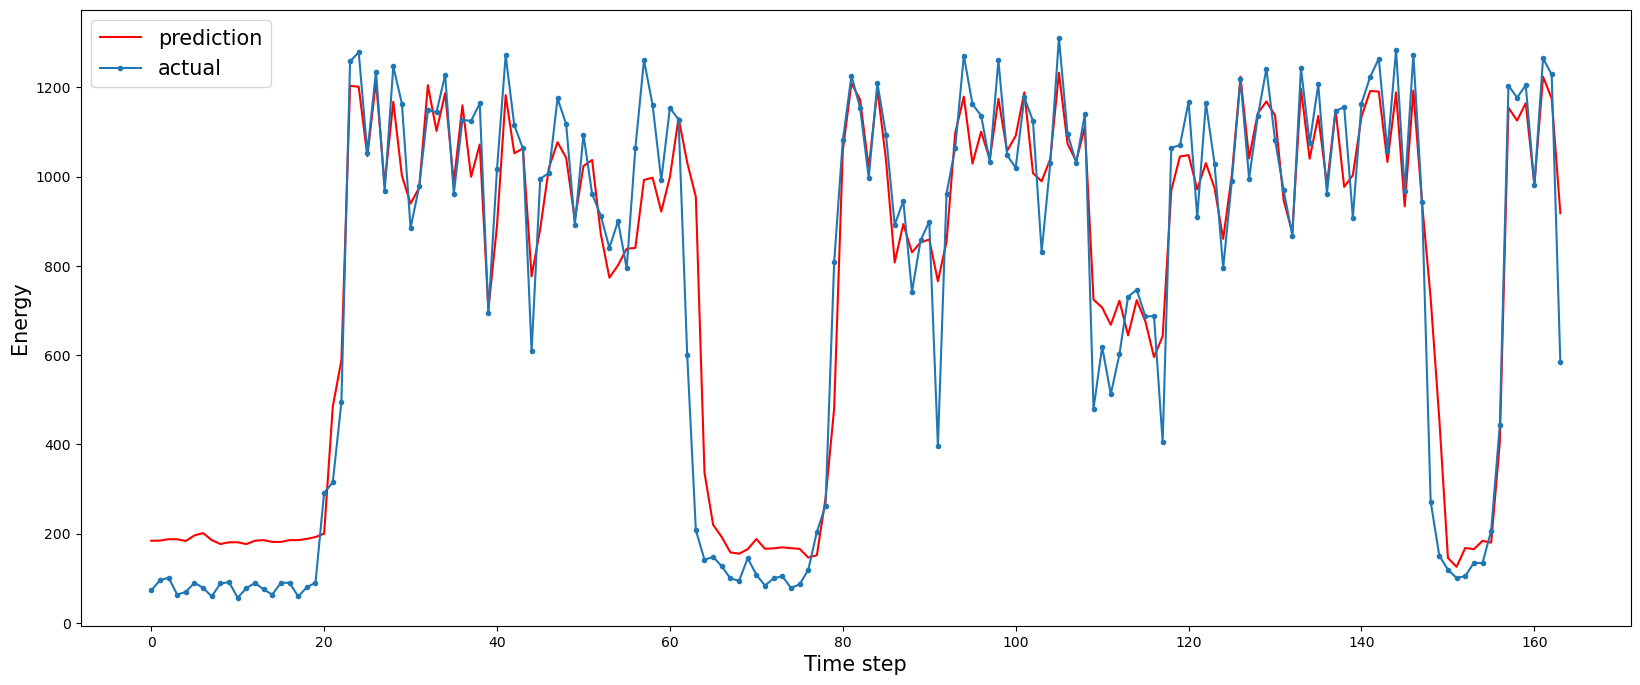

In [16]:
plt.figure(figsize=(20,8))
plt.plot(predictions, label='prediction', color="r")
plt.plot(original, label='actual', marker='.')
plt.legend()
plt.ylabel('Energy', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)

plt.show()

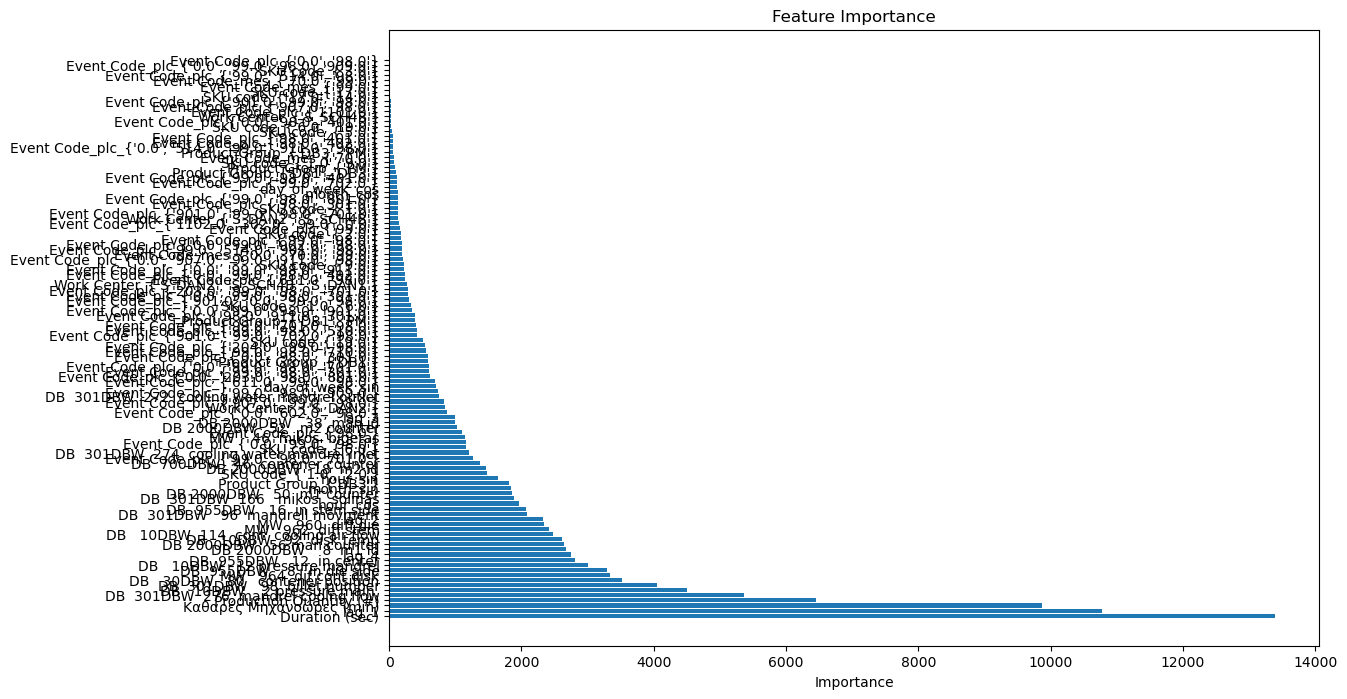

In [17]:
# Assuming 'model' is your trained XGBoost model
# Get feature importances
importance = model.get_score(importance_type='weight')

# Convert the importance dictionary to a DataFrame for easier plotting
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Plotting the feature importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

<Figure size 1200x800 with 0 Axes>

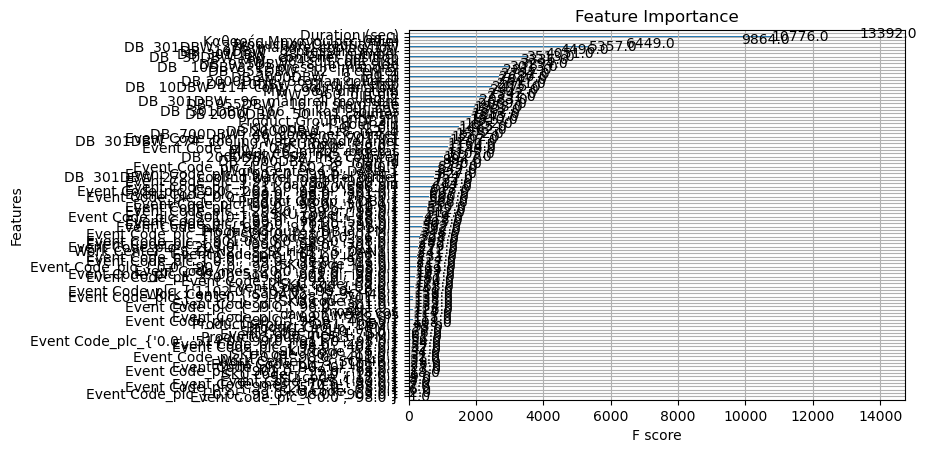

In [18]:
# Plot feature importance
from xgboost import plot_importance

plt.figure(figsize=(12, 8))
plot_importance(model, importance_type='weight')  # You can also use 'gain' or 'cover'
plt.title('Feature Importance')
plt.show()


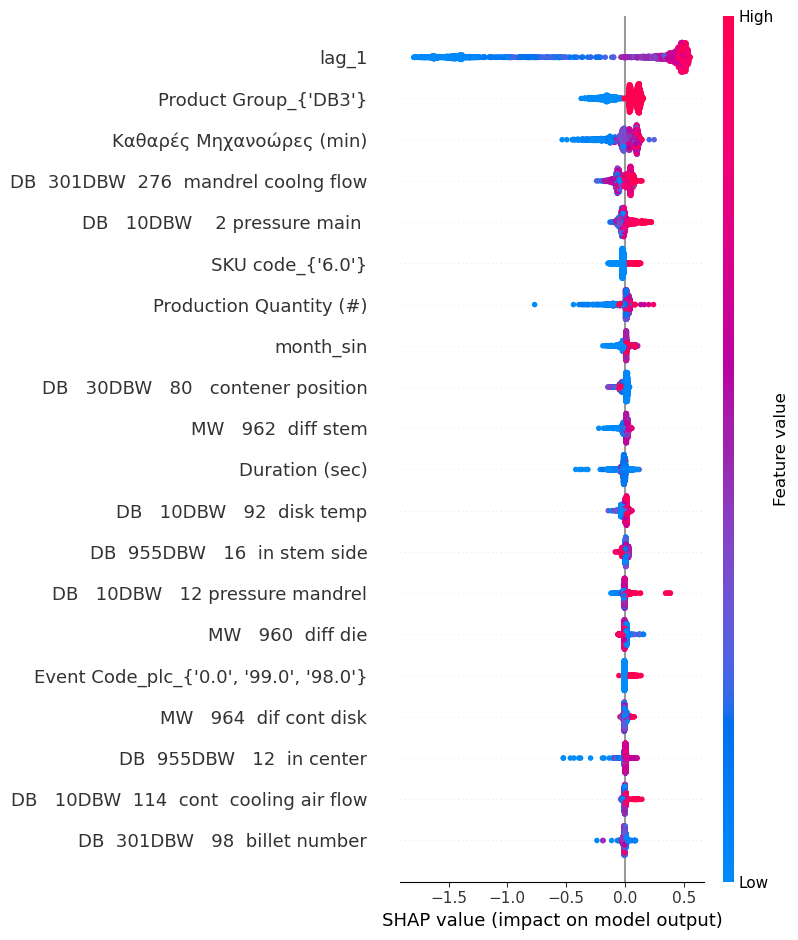

In [19]:
import shap

# Initialize the SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_combined)

# Visualize the SHAP values
shap.summary_plot(shap_values, X_combined)